In [4]:
import math
import sys
sys.path.append('../figures/scripts/')
import funclib as flib

Generate Table S1

In [6]:
latin2common = pd.read_csv("../data/latin2common_shortened.txt",sep="\t").set_index("Species").to_dict()["Common_names"]

groups = ["Mammals","Birds","Snakes"]
refs = ["Homo_sapiens","Gallus_gallus","Thamnophis_elegans"]
lh_cols = ["Maximum longevity (yrs)", "Gestation/Incubation (days)", "Birth weight (g)", "Adult weight (g)" ]
cols = ["Species","Common_name","Group","alpha","alpha_lwr","alpha_upr","xz_a", "xz_a_lwr", "xz_a_upr",
        "predicted_alpha","predicted_alpha_dnms", "dnm_alpha", "Maternal", "Paternal", "trios", 
        "MutPerYearUCSC","G","AssemblyStatus","ScaffoldN50","ContigN50","AssemblyAccession","Sex","Pi_het","anage_Species","TimeTree"] + lh_cols

# Only read once
anage = pd.read_csv("../pgls_files/anage_data.txt",sep="\t")
anage.columns = [c.replace("Species","Subspecies") for c in anage.columns]
anage["anage_Species"] = anage["Genus"] + "_" + anage["Subspecies"]
timetree = pd.read_csv("../trees/TimeTree.spname_map.tab",sep="\t")
timetree.columns = ["Species","TimeTree"]
timetree_dict = timetree.set_index("Species")["TimeTree"].to_dict()
impute = pd.read_csv("../pgls_files/impute_species.txt",sep="\t")
gen_times = pd.read_csv("../data/generation_times.csv")
pred_evo_alphas = pd.read_csv("../data/XA_2exposure-model_alphas.csv")
pred_dnm_alphas = pd.read_csv("../data/DNM_2exposure-model_alphas.csv")

# Initialise data frame
table_s1 = pd.DataFrame()

# Iterate and read data for each taxon
for i,g in enumerate(groups):
    
    # Read species list
    with open("../data/{}.txt".format(g)) as species_list:
        species = [line.strip().split(",") for line in species_list][0]
    
    # Add assembly metadata
    meta_data = pd.read_csv("../data/{}_assembly_metadata.csv".format(g))
    meta_data = meta_data[meta_data.Species.isin(species)].reset_index(drop=True)
    meta_data["Common_name"] = [latin2common[sp] for sp in meta_data.Species]
                
    # Add X(Z)/A alphas
    xz_a_alphas = pd.read_csv("../scripts/alphas/{}.{}.LM.tsv".format(g, refs[i]),sep="\t")
    xz_a_alphas = xz_a_alphas[xz_a_alphas.mut_type=="mod"]
    xz_a_alphas.columns = [c.replace("species","Species") for c in xz_a_alphas.columns]
    meta_data = flib.add_columns_to_df(meta_data, xz_a_alphas, "Species", 
                                       ["alpha","alpha_lwr","alpha_upr","xz_a", "xz_a_lwr", "xz_a_upr"])
    
    # Add generation times
    gen_times.columns = [c.replace("species","Species") for c in gen_times.columns]
    meta_data = flib.add_columns_to_df(meta_data, gen_times, "Species", 
                                       ["G"])
    
    # Add predicted alphas (evo)
    pred_evo_alphas.columns = [c.replace("species","Species") for c in pred_evo_alphas.columns]
    meta_data = flib.add_columns_to_df(meta_data, pred_evo_alphas, "Species", 
                                       ["predicted_alpha","MutPerYearUCSC"]) #+ lh_cols)
    
    # Add predicted alphas (DNMs)
    pred_dnm_alphas.columns = [c.replace("species","Species") for c in pred_dnm_alphas.columns]
    meta_data = flib.add_columns_to_df(meta_data, pred_dnm_alphas, "Species", 
                                       ["Age","Paternal","Maternal","dnm_alpha","predicted_alpha_dnms","trios"])
    
    # Add substitute species in TimeTree/AnAge
    meta_data = flib.add_columns_to_df(meta_data, impute, "Species", ["anage_Species"])
    meta_data = flib.add_columns_to_df(meta_data, timetree, "Species", ["TimeTree"])
    if g!="Snakes":
        meta_data["TimeTree"] = [r.Species if r.Species not in timetree_dict else timetree_dict[r.Species] for i,r in meta_data.iterrows()]
    
    # Add life history traits
    meta_data = flib.add_columns_to_df(meta_data, anage, "anage_Species", lh_cols)
    
    # Column names and formatting 
    meta_data["Group"] = g
    meta_data = meta_data[cols]
    #meta_data.columns = [c[0].capitalize()+c[1:] for c in meta_data.columns]
    table_s1 = pd.concat([table_s1,meta_data])

In [7]:
extra_pred_dnms = pred_dnm_alphas[~pred_dnm_alphas.Species.isin(table_s1.Species)]

In [8]:
for c in table_s1:
    if c not in extra_pred_dnms.columns:
        extra_pred_dnms[c] = np.nan

<ipython-input-8-0fd490f15301>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_pred_dnms[c] = np.nan


In [9]:
table_s1 = pd.concat([table_s1, extra_pred_dnms[table_s1.columns]])

In [10]:
replace_col_names = {"Predicted_alpha": "Predicted_alpha_evo",
                     "TimeTree": "TimeTree_Species",
                     "Dnm_alpha": "Alpha_dnm",
                     "Paternal": "Paternal_dnms",
                     "Maternal": "Maternal_dnms",
                     "Trios": "n_Trios",
                     "G": "Generation_time_y",
                     "Maximum longevity (yrs)":"Maximum_longevity", 
                     "Gestation/Incubation (days)":"Gestation", 
                     "Birth weight (g)":"Birth_weight", 
                     "Adult weight (g)":"Adult_weight" 
                    }

In [11]:
table_s1.columns = [c[0].capitalize()+c[1:] for c in table_s1.columns]
table_s1.columns = [replace_col_names[c] if c in replace_col_names else c for c in table_s1.columns]

In [1]:
table_s1.to_csv("../data/Table_S1_ee5.csv",na_rep='NaN')

NameError: name 'table_s1' is not defined

In [2]:
t1 = pd.read_csv("../data/Table_S1_ee5.csv")

<AxesSubplot:xlabel='Predicted_alpha_dnms', ylabel='Alpha_dnm'>

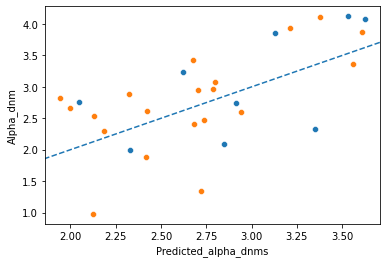

In [5]:
subdnm = t1[(t1.n_Trios>1) & (t1.Species!="Microcebus_murinus") & (t1.Species!="Ficedula_albicollis")]
sns.scatterplot(data=subdnm,x="Predicted_alpha_dnms",y="Alpha_dnm")
sns.scatterplot(data=t1,y="Alpha", x="Predicted_alpha_evo")
flib.identity_line()

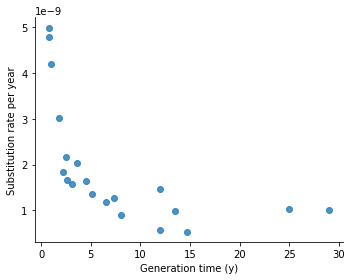

In [15]:
f,ax = plt.subplots(figsize=[5,4])
ax.scatter(subd.Generation_time_y, subd.MutPerYearUCSC/1e6,alpha=0.8)
sns.despine()
ax.set_xlabel("Generation time (y)")
ax.set_ylabel("Substitution rate per year")
plt.tight_layout()
#plt.savefig("pdfs/Subrate_year_vs_G.pdf")